# Goodreads Data User #2 Analysis

## Initial Data Exploration

In [72]:
#Ignore deprecated warning buried in 3rd party packages
#(comment initially to look at warning and suppress warnings later)
import warnings
warnings.filterwarnings('ignore')

#Import useful libraries and open the file
import pandas as pd #dataframe organization
import os
import numpy as np
import seaborn as sns #stats plotting toolbox
from scipy import stats
import matplotlib.pyplot as plt #plotting
import matplotlib.gridspec as gridspec #plotting
import util #my library with some useful functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, precision_score, accuracy_score,\
recall_score, roc_curve, auc#classifier performance
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV, calibration_curve #classifier calibration
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import KFold
import requests


#Read in a user's file
test_df = pd.read_csv("../input/goodreads_library_export_user2.csv", encoding = "ISO-8859-1")

print('Looking at the first few rows: ')
test_df.head()



Looking at the first few rows: 


,Book Id,Title,Author,Author l-f,Additional Authors,ISBN,ISBN13,My Rating,Average Rating,Publisher,...,Private Notes,Read Count,Recommended For,Recommended By,Owned Copies,Original Purchase Date,Original Purchase Location,Condition,Condition Description,BCID
0,13581476,FLCL Omnibus,Gainax,"Gainax, Gainax",Hajime Ueda,1595828680,9.781596e+12,0,3.88,Dark Horse Comics,...,NaN,1,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,34128219,"La Belle Sauvage (The Book of Dust, #1)",Philip Pullman,"Pullman, Philip",NaN,0375815309,9.780376e+12,4,4.20,Alfred A. Knopf,...,NaN,1,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
2,4025275,War's Unwomanly Face,Svetlana Alexievich,"Alexievich, Svetlana",NaN,5010004941,9.785010e+12,5,4.52,Progress Publishers,...,NaN,1,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
3,36521370,Cherry,Nico Walker,"Walker, Nico",NaN,178733094X,9.781787e+12,0,4.02,Jonathan Cape,...,NaN,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
4,15177,Bridge of Birds (The Chronicles of Master Li a...,Barry Hughart,"Hughart, Barry",NaN,0345321383,9.780345e+12,0,4.29,Del Rey,...,NaN,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN


In [73]:
#Understand how many data points and what is potentially contained within each point

print('Number of data total data points: ', test_df.shape[0])
print('Number of features for each data point: ', test_df.shape[1])
print('')
print('A list of all columns: ')
print(test_df.columns)

Number of data total data points:  570
Number of features for each data point:  31

A list of all columns: 
Index(['Book Id', 'Title', 'Author', 'Author l-f', 'Additional Authors',
       'ISBN', 'ISBN13', 'My Rating', 'Average Rating', 'Publisher', 'Binding',
       'Number of Pages', 'Year Published', 'Original Publication Year',
       'Date Read', 'Date Added', 'Bookshelves', 'Bookshelves with positions',
       'Exclusive Shelf', 'My Review', 'Spoiler', 'Private Notes',
       'Read Count', 'Recommended For', 'Recommended By', 'Owned Copies',
       'Original Purchase Date', 'Original Purchase Location', 'Condition',
       'Condition Description', 'BCID'],
      dtype='object')


In [74]:
#Remove all entries w/ "0" in the "My Rating" field, these haven't been read/reviewed
test_df.drop(test_df.loc[test_df['My Rating'] == 0].index, inplace=True)

#Now, look at the new size of the dataset
print('Number of data total data points: ', test_df.shape[0])


Number of data total data points:  378


In [75]:
#Data looks pretty sparse. Show a histogram of the number of populated features

#Replace all '0' wth null, they are the same here
test_df.replace(to_replace=0, value=np.nan , inplace=True)
test_df.head()

percent_filled_cells = pd.DataFrame((test_df.notna().sum()/test_df.shape[0]*100), columns=['Data Present (%)'])

percent_filled_cells.style.bar(color=['#5fba7d'])

#Data cleaning - All entries whose fields contain 0% are eliminated
test_df.drop(columns=percent_filled_cells.loc[percent_filled_cells['Data Present (%)'] < 1].index, inplace=True)

percent_filled_cells_edited = pd.DataFrame((test_df.notna().sum()/test_df.shape[0]*100), columns=['Data Present (%)'])

percent_filled_cells.style.bar(color=['#5fba7d'])



,Data Present (%)
Book Id,100
Title,100
Author,100
Author l-f,100
Additional Authors,40.2116
ISBN,96.5608
ISBN13,96.8254
My Rating,100
Average Rating,100
Publisher,98.9418


### Misc Data Distribution


In [76]:
#Checking if the year published is normally distributed

k2, p = stats.normaltest(test_df['Year Published'].values, nan_policy='omit')

print('Probability that year published is normally distributed: ' + '%1.4f' % p)



Probability that year published is normally distributed: 0.0000


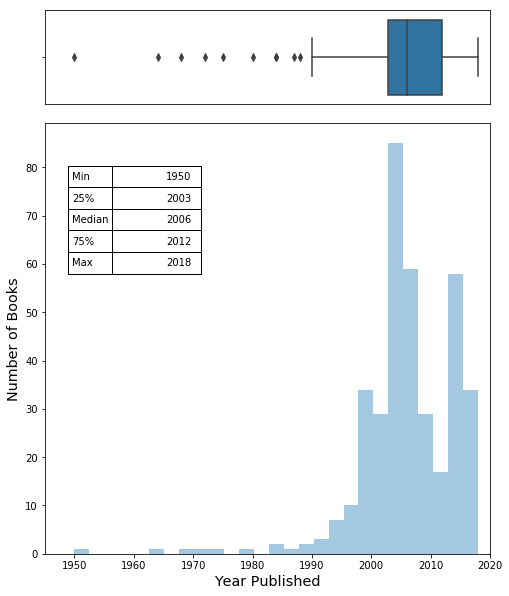

In [77]:
#Let's look at some at teh various statistucs about the books

#When are the books published

#plt.figure(1, figsize=(15, 7))
# plt.subplot(121)
# plt.hist(test_df['Year Published'], bins=np.arange(test_df['Year Published'].min(), test_df['Year Published'].max(), 5))
# plt.xlabel('Year Published')
# plt.ylabel('Number of Books')

# plt.subplot(122)
# plt.hist(test_df.loc[test_df['Number of Pages'].notna()]['Number of Pages'])
# plt.xlabel('Number of Pages')
# plt.ylabel('Number of Books')


# plt.show()

#Set up the plotting space
plt.figure(1, figsize=(16, 10))
gs = gridspec.GridSpec(5, 2)
gs.update(left=0.05, right=0.9)

plt.subplot(gs[0, 0])
ax = sns.boxplot(test_df['Year Published'].dropna())
ax.set_xticks([])
ax.set_xlabel('')
ax.set_xlim(1945, 2020)

plt.subplot(gs[1:, 0])
ax1 = sns.distplot(test_df['Year Published'].dropna(), norm_hist=False, kde=False)
ax1.set_xlim(1945, 2020)
plt.xlabel('Year Published', fontsize='x-large')
plt.ylabel('Number of Books', fontsize='x-large')

#ax = plt.subplot(gs[2:4, 1])
year_summ = test_df['Year Published'].dropna().describe()
ax1.add_table(plt.table(cellText=[['%1.0f' % year_summ['min']], ['%1.0f' % year_summ['25%']], ['%1.0f' % year_summ['50%']], ['%1.0f' % year_summ['75%']], ['%1.0f' % year_summ['max']]], rowLabels=['Min', '25%', 'Median', '75%', 'Max'], loc='left', bbox=[.15,.65,.2,.25]))
plt.show()


In [78]:
#Checking if the num pages is normally distributed

k2, p = stats.normaltest(test_df['Number of Pages'].values, nan_policy='omit')

print('Probability that year published is normally distributed: ' + '%1.4f' % p)


Probability that year published is normally distributed: 0.0000


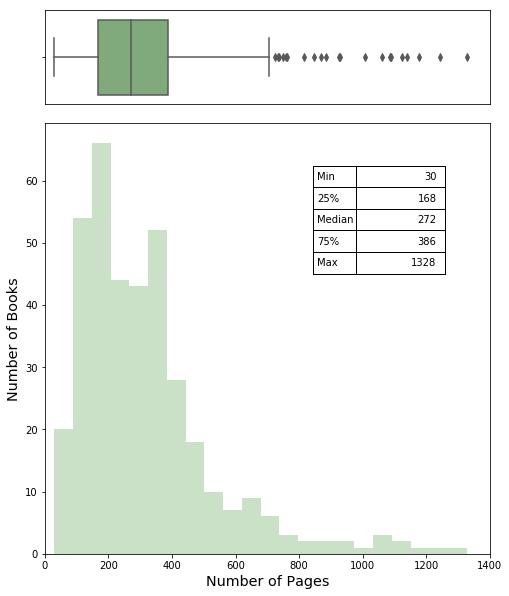

In [79]:
#Set up the plotting space
plt.figure(1, figsize=(16, 10))
gs = gridspec.GridSpec(5, 2)
gs.update(left=0.05, right=0.9)

plt.subplot(gs[0, 0])
ax = sns.boxplot(test_df['Number of Pages'].dropna(), color=sns.xkcd_rgb["faded green"])
ax.set_xticks([])
ax.set_xlabel('')
ax.set_xlim(0, 1400)


plt.subplot(gs[1:, 0])
ax1 = sns.distplot(test_df['Number of Pages'].dropna(), color=sns.xkcd_rgb["faded green"], norm_hist=False, kde=False)
ax1.set_xlim(0, 1400)
plt.xlabel('Number of Pages', fontsize='x-large')
plt.ylabel('Number of Books', fontsize='x-large')

#ax = plt.subplot(gs[2:4, 1])
pages_summ = test_df['Number of Pages'].dropna().describe()
ax1.add_table(plt.table(cellText=[['%1.0f' % pages_summ['min']], ['%1.0f' % pages_summ['25%']], ['%1.0f' % pages_summ['50%']], ['%1.0f' % pages_summ['75%']], ['%1.0f' % pages_summ['max']]], rowLabels=['Min', '25%', 'Median', '75%', 'Max'], loc='left', bbox=[.7,.65,.2,.25]))
plt.show()

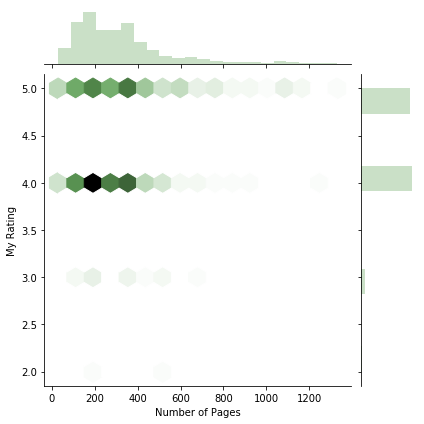

In [80]:
#Show the joint distribution of average rating and number of pages
sns.jointplot(x='Number of Pages', y='My Rating', data=test_df, kind="hex", color=sns.xkcd_rgb["faded green"])
plt.show()


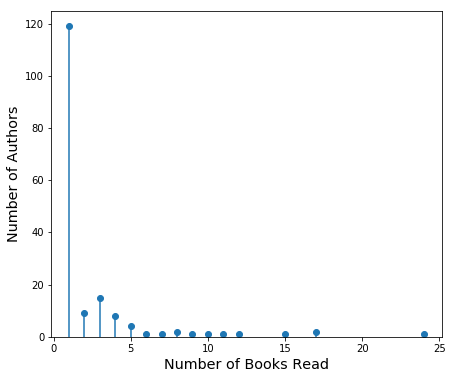

In [81]:
#Categorize the authors so it's easier to group them 
labels, uniques = pd.factorize(test_df['Author'])

#Find the number of books read for each author
author_count, author_index = np.histogram(labels, bins = range(uniques.size+1))
#Add the author count to our originial datframe for later use
test_df['Number of Books Read by this Author']=pd.Series(labels, index=test_df.index).map(lambda x: author_count[x])
#Create a histogram for authors: number of books read
author_freq, num_books = np.histogram(author_count, bins = range(1,26))

#Create a dataframe with only hist bins that were populated
df_author_info = pd.DataFrame(data={'Number of Books': num_books[:-1], 'Author Frequency': author_freq})
df_author_info.drop(df_author_info.loc[df_author_info['Author Frequency'] == 0].index, inplace=True)
#df_author_info.set_index('Number of Books', inplace=True)

#Show the author information
#df_author_info.style.bar(color='orange')
#ax = df_author_info.plot.bar(x='Number of Books', y='Author Frequency')

plt.figure(1, figsize=(7, 6))
(markerline, stemlines, baseline) = plt.stem(df_author_info['Number of Books'], df_author_info['Author Frequency'])
plt.setp(baseline, visible=False)
plt.ylim(0, 125)
plt.xlabel('Number of Books Read', fontsize='x-large')
plt.ylabel('Number of Authors', fontsize='x-large')
plt.show()



In [82]:
labels, uniques = pd.factorize(test_df.loc[test_df['Number of Books Read by this Author'] >=15]['Author'])

for author in uniques:
    print('Author: ' + author + ', Number of Books: ' + str(test_df.loc[test_df['Author'] == author]['Number of Books Read by this Author'].iloc[0]))


Author: Haruki Murakami, Number of Books: 17
Author: Neil Gaiman, Number of Books: 24
Author: Brian K. Vaughan, Number of Books: 15
Author: Bill Willingham, Number of Books: 17


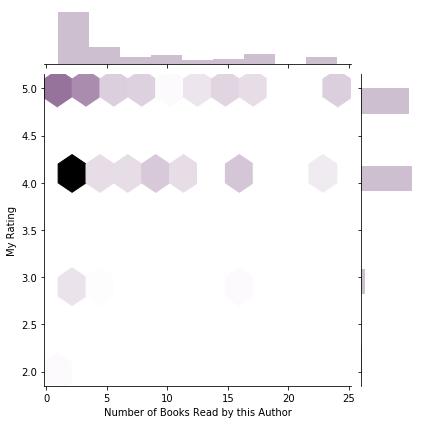

In [83]:
#Show the joint distribution of my rating and number of books read by this author
sns.jointplot(x='Number of Books Read by this Author', y='My Rating', data=test_df, kind="hex", color=sns.xkcd_rgb["dusty purple"])
plt.show()

### Ratings Data

The following analysis investigates general trends regarding the books' ratings. Goodreads users rate books on a scale from 1-5 with increments of 1 (i.e., 1, 2, 3, 4, 5).

First, the mean ratings for all books read by this user is shown. The ratings distribution appear to be Gaussian in nature with $\mu=4.10$ and $\sigma=0.25$. A Chi-squared test was performed to evaluate the goodness of fit of the Gaussian curve on the global ratings distribution data. The test yielded the following values: $\chi^{2}=21.40$ and $p=0.9997$. In other words, the probability that our null hypothesis that this Gaussian function is a good fit for our data is correct is 99.97%. In layman terms, it seems to be a very good fit.

In the same vein, we look at this particular users' ratings. Because the user is limited to only 5 different ratings (1,2,..5), the histogram takes on a more discretized appearance. A discussion with the user revealed that she tends to select books that she believes she will like, leading to the skew toward higher ratings. Again I tried to fit a Gaussian curve on the user's data. The Gaussian parameters were calculated as: $\mu=4.42$ and $\sigma=0.59$. A Chi-squared test was performed to evaluate the goodness of fit of the Gaussian curve on the user's ratings distribution data. The test yielded the following values: $\chi^{2}=22.41$ and $p=0$. In other words, the probability that our null hypothesis that this Gaussian function is a good fit for our data is correct is ~0%. In layman terms, the Gaussian curve is a very bad fit for the user data. This is not surprising as there are too few bins (i.e. degrees of freedom in the Chi-squared test) to fit a Gaussian curve to the data with any statistical significance.



Chi Squared Test for global ratings of books
Probability that global ratings are normally distributed: 0.999757
Gaussian fit parameters: mean=4.103, standard deviation=0.2548

Chi Squared Test for one user's ratings of books
Probability that global ratings are normally distributed: 5.344e-05
Gaussian fit parameters: mean=4.423, standard deviation=0.5871


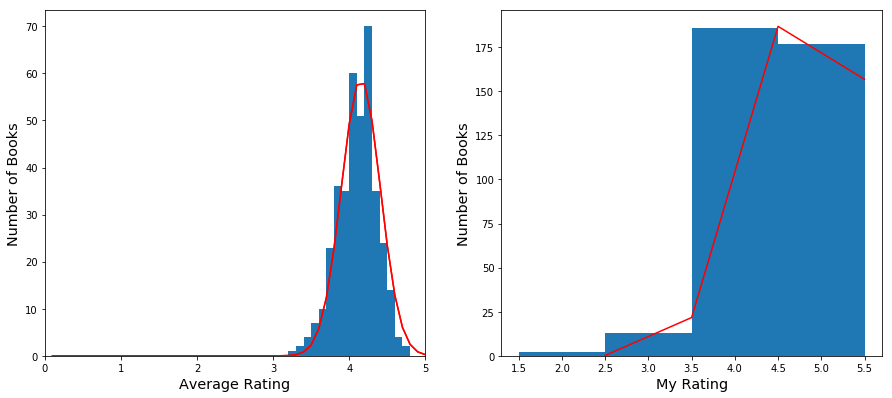

In [84]:
#Global and User ratings distributions

#Universal average ratings of the books
plt.figure(1, figsize=(15, 14))
plt.subplot(221)

num_points = test_df['Average Rating'].shape[0]
#Plot the histogram
hist_bins = np.arange(0, 5.1, 0.1)
actual_count, actual_bins, ignored = plt.hist(test_df['Average Rating'], bins = hist_bins)
#Find a guassian fit to the distribution curve
param = stats.norm.fit(test_df['Average Rating'])
gprob = np.diff(stats.norm.cdf(actual_bins, loc=param[0], scale=param[1]))
plt.plot(actual_bins[1:],gprob*num_points, 'r-')
plt.xlim(0,5)
plt.xlabel('Average Rating', fontsize='x-large')
plt.ylabel('Number of Books', fontsize='x-large')

#Performing a chi-squared test to see if the guassian fit is good
gprob = np.diff(stats.norm.cdf(actual_bins, loc=param[0], scale=param[1]))
plt.plot(actual_bins[1:],gprob*num_points, 'r-')
nch, npval = stats.chisquare(actual_count, gprob*num_points)
print('Chi Squared Test for global ratings of books')
print('Probability that global ratings are normally distributed: {:.6}'.format(npval) )
print('Gaussian fit parameters: mean={:.4}, standard deviation={:.4}'.format(param[0], param[1]))
print('')

#My ratings of books
plt.subplot(222)
my_bins = np.arange(1.5, 6.5, 1)
actual_count_user, my_bins, ignored = plt.hist(test_df['My Rating'], bins=my_bins)
plt.xlabel('My Rating', fontsize='x-large')
plt.ylabel('Number of Books', fontsize='x-large')

#Find a guassian fit on the user's ratings
param_user = stats.norm.fit(test_df['My Rating'])
gprob_user = np.diff(stats.norm.cdf(my_bins, loc=param_user[0], scale=param_user[1]))
plt.plot(my_bins[1:],gprob_user*num_points, 'r-')
#Perform a chi squared test to detemine goodness of fit of guassian on user's ratings
nch_user, npval_user = stats.chisquare(actual_count_user, gprob_user*num_points)
print('Chi Squared Test for one user\'s ratings of books')
print('Probability that global ratings are normally distributed: {:.4}'.format(npval_user) )
print('Gaussian fit parameters: mean={:.4}, standard deviation={:.4}'.format(param_user[0], param_user[1]))


## Optimizing Book Selection

Ultimately the goal of this model is to optimize book selection. If we could build a model that accurately predicts a user's rating, then the model could be used to make book recommendations to our reader.

The first and most obvious way to recommend books to the reader is by choosing books with high global ratings. Consequently, the analysis presented here first explores the relationship between the global ratings of a book and the user's ratings.

Next, I investigated the use of classifiers to predict whether or not the user would rate the book as a '5'. Two different types of classifiers were explored here: random forest classifier and naiive bayes classifier. This analysis looks at different feature selection and classifier calibration as a way to improve performance. Cross validation analysis is also performed to give more accurate model prediction performance.

### User Rating vs. Global Rating

Intuition leads us to the following hypothesis: there is a positive relationship between a book's global ratings and a user's ratings.

We first look at the joint distribution between these two variables. In general, the joint distribution seems to confirm our hypothesis. The books with User Rating of '5' were more likely to have a higher global rating when compared to books with a User Rating of '4'.

To make this observation a little clearer, I show the conditional probability distribution functions. For both, a Gaussian curve was fitted to the distributions. The null hypothesis that the fitted curve is a good fit for the distributions is accepted with a probability > 99.99% for both. For books that received a user rating of 5, the global ratings had the following properties: $\mu=4.21$ and $\sigma=0.22$. Likewise, for books that received a user rating of 5, the global ratings had the following properties: $\mu=4.04$ and $\sigma=0.24$. The conclusions drawn from this analysis is that there is a clear trend between global ratings and this particular user's ratings.


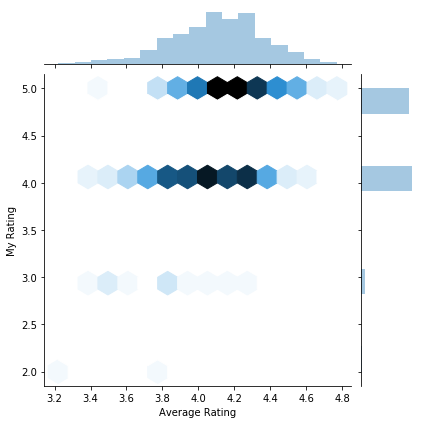

In [85]:
#Create a series with the differece between the ratings
diff_ratings = test_df['Average Rating']-test_df['My Rating']

# diff_hist_bins = np.arange(-3, 3, 0.1)
# plt.hist(diff_ratings, bins=diff_hist_bins)
# plt.xlabel('Average Rating - My Rating')
# plt.ylabel('Number of Books')

# plt.show()

#Show the joint distribution of average rating and user rating
sns.jointplot(x='Average Rating', y='My Rating', data=test_df, kind="hex")
plt.show()


Chi Squared Test for User Rating = 5
Probability that the null hypothesis stating that global ratings are normally distributed: 0.999977
Gaussian fit parameters: mean=4.205, standard deviation=0.2158

Chi Squared Test for User Rating < 5
Probability that the null hypothesis stating that global ratings are normally distributed: 0.999994
Gaussian fit parameters: mean=4.013, standard deviation=0.2528


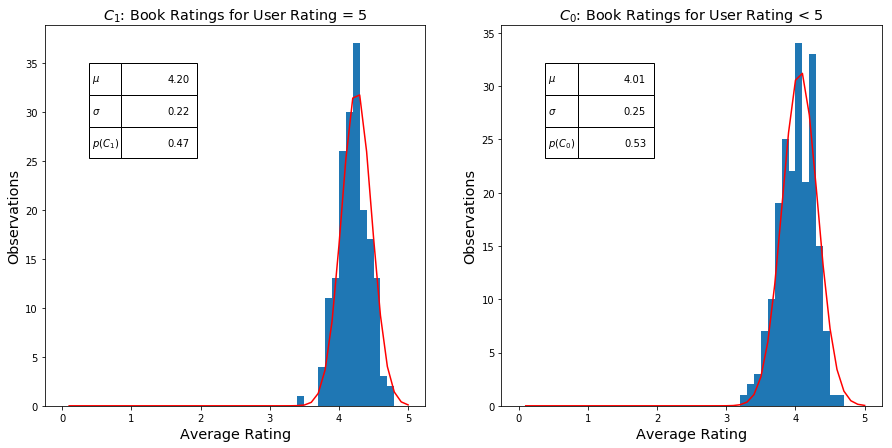

In [86]:
#Show the condition probablilities of global ratings given the user ratings

#Show the histogram of global ratings for user rating = 5
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
#plt.figure(1, figsize=(15, 7))
#plt.subplot(121)
ax[0].set_xlabel('Average Rating', fontsize='x-large')
ax[0].set_ylabel('Observations', fontsize='x-large')
ax[0].set_title('$C_{1}$: Book Ratings for User Rating = 5', fontsize='x-large')
#Define the hist bins
hist_bins = np.arange(0, 5.1, 0.1)
#Define a series of average ratings where user rated as '5'
cond_ratings_5 = test_df.loc[test_df['My Rating'] == 5]['Average Rating']
#Fit a guassian curve and plot histogram and fitted curve
actual_count, actual_bins, param_mean_5, param_std_5, nch_5, npval_5 = util.guass_fit_dist(cond_ratings_5, hist_bins, ax[0])


#Print guassian params and goodness of fit test results
print('Chi Squared Test for User Rating = 5')
print('Probability that the null hypothesis stating that global ratings are normally distributed: {:.6}'.format(npval_5) )
print('Gaussian fit parameters: mean={:.4}, standard deviation={:.4}'.format(param_mean_5, param_std_5))
print('')

#Show the histogram of global ratings for user rating <= 4
#plt.subplot(122)
ax[1].set_xlabel('Average Rating', fontsize='x-large')
ax[1].set_ylabel('Observations', fontsize='x-large')
ax[1].set_title('$C_{0}$: Book Ratings for User Rating < 5', fontsize='x-large')
#Define a series of average ratings where user rated as '4'
cond_ratings_4 = test_df.loc[test_df['My Rating'] <= 4]['Average Rating']
#Fit a guassian curve
actual_count, actual_bins, param_mean_4, param_std_4, nch_4, npval_4 = util.guass_fit_dist(cond_ratings_4, hist_bins, ax[1])
#Print guassian params and goodness of fit test results
print('Chi Squared Test for User Rating < 5')
print('Probability that the null hypothesis stating that global ratings are normally distributed: {:.6}'.format(npval_4) )
print('Gaussian fit parameters: mean={:.4}, standard deviation={:.4}'.format(param_mean_4, param_std_4))

#Add tables to the figures with key parameters
p_c1 = float(cond_ratings_5.size)/(float(cond_ratings_5.size) + float(cond_ratings_4.size))
p_c0 = float(cond_ratings_4.size)/(float(cond_ratings_5.size) + float(cond_ratings_4.size))
ax[0].table(cellText=[['%1.2f' % param_mean_5], ['%1.2f' % param_std_5], ['%1.2f' % p_c1]], rowLabels=['$\mu$', '$\sigma$', '$p(C_{1})$'], bbox=[.2,.65,.2,.25])
ax[1].table(cellText=[['%1.2f' % param_mean_4], ['%1.2f' % param_std_4], ['%1.2f' % p_c0]], rowLabels=['$\mu$', '$\sigma$', '$p(C_{0})$'], bbox=[.2,.65,.2,.25])

plt.show()


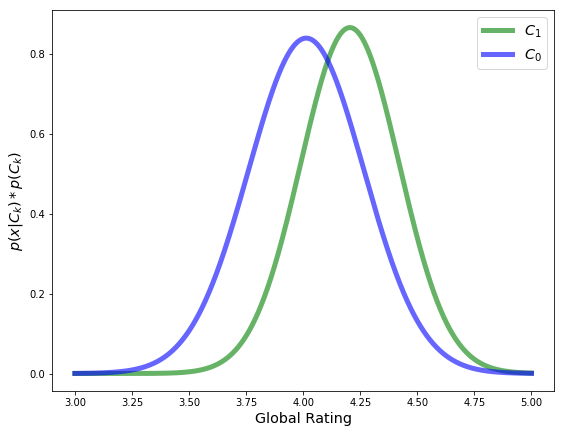

Intersection occurs at x = 4.109109109109109


In [87]:
#Make a tradeoff probabability curve of the Bayes theory
fig1 = plt.figure(1, figsize=(9, 7))

x = np.linspace(3, 5, 1000)
p_x_c1 = stats.norm.pdf(x, loc=param_mean_5, scale = param_std_5)*p_c1
p_x_c0 = stats.norm.pdf(x, loc=param_mean_4, scale = param_std_4)*p_c0
plt.plot(x, p_x_c1, 'g-', lw=5, alpha=0.6, label='norm pdf')
plt.plot(x, p_x_c0, 'b-', lw=5, alpha=0.6, label='norm pdf')
plt.xlabel('Global Rating', fontsize='x-large')
plt.ylabel('$p(x|C_{k})*p(C_{k})$', fontsize='x-large')
plt.axes().legend(['$C_{1}$', '$C_{0}$'], fontsize='x-large')
plt.show()



#Find the point (global rating) where the decision rule changes (intersection)
for i, val in enumerate(p_x_c0):
    if val < p_x_c1[i]:
        break
print('Intersection occurs at x = ' + str(x[i]))


### Classification using Global Rating Feature Only

Here, I investigate the use of a classifier to make suggestions to the user. The classifier is a binary classifier and will predict if the user's rating is either '5' or less than '5'. The idea is that reading a book is a large time investment and the user may only want to find books he/she really enjoys. To this end, there are two important performance metrics in this project: accuracy and precision. Accuracy give a general overall sense for how well the model performs. Maximizing precision allows us to optimize for avoiding books that were not considered amazing reading material. (Alternatively, if the user was very concerned with potentially missing good books, the model would place higher importance on recall.)

At this stage in the analysis, the classifier only incorporates one feature input: book's global average rating. In this section, the training and test datasets will be the same across classifiers. The training and test data was split 75%/25% at random. 


#### Naiive Bayes Classifier w/ Global Rating Feature Only

Prior to extensive calibration of the classifier, the accuracy of the classifier is approximately 71%. In other words, the classifier build can accurately predict whether a user will assign a '5' 71% of the time. The classifier's precision is 82% and the recall is 18%.

In [88]:
#Build a naiive bayes classifier to find books' ratings

model_bayes = GaussianNB()
features = np.array(test_df['Average Rating']).reshape(-1, 1)
labels = np.array(test_df['My Rating']==5).reshape(-1, 1)
kfold_builder = KFold(n_splits=10, random_state=29)


print('Naiive Bayes Classifier Performance')
ignore = util.print_kfold_classifier_metrics(model_bayes, kfold_builder, features, labels)


Naiive Bayes Classifier Performance
Accuracy of model: mean= 0.61, std. dev. = 0.11
Precision of model: mean= 0.62, std. dev. = 0.23
Recall of model: mean= 0.68, std. dev. = 0.23


### Expanding features


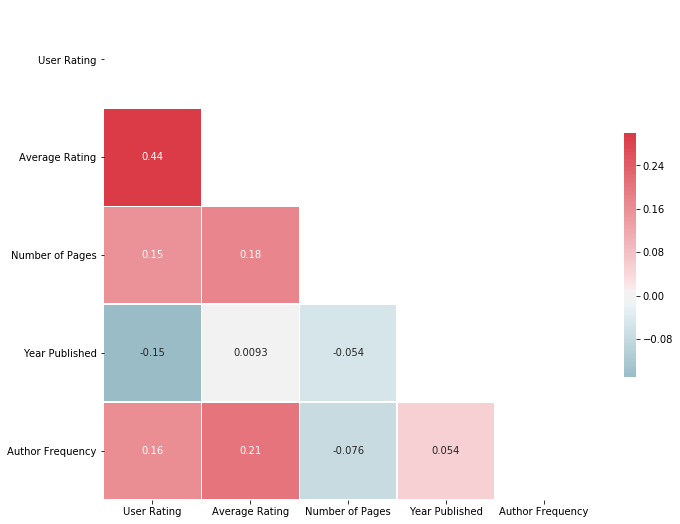

In [89]:
#Investigate relationship between # of books read by an author and user's ratings
#Hypothesis: There is a positive relationship between number of books read by an author and rating

#Look at correlation coefficients between author count and ratings
cols_select = ['My Rating', 'Average Rating', 'Number of Pages', 'Year Published', 'Number of Books Read by this Author']
corr = test_df[cols_select].corr()


# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

ticklabels = ['User Rating', 'Average Rating', 'Number of Pages', 'Year Published', 'Author Frequency']

# Draw the heatmap with the mask and correct aspect ratio
corr_matrix = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, yticklabels=ticklabels, xticklabels=ticklabels, annot=True)

for item in corr_matrix.get_yticklabels():
    item.set_rotation(0)
for item in corr_matrix.get_xticklabels():
    item.set_rotation(0)

plt.show()


In [90]:
#Construct a new Bayes classifier with 2 features (average rating and number of books read by this author)

#Define the features set
features = np.append(np.array(test_df['Average Rating']).reshape(-1, 1), np.array(test_df['Number of Books Read by this Author']).reshape(-1, 1), axis=1)
#Define the labels set
labels = np.array(test_df['My Rating']==5).reshape(-1, 1)

#Define the model
model_bayes2 = GaussianNB()

#Define the k-fold 
kfold_builder = KFold(n_splits=10, random_state=29)

#Run 10-fold cross validation testing on model
print('Naiive Bayes Classifier Performance with Two Features')
ignore = util.print_kfold_classifier_metrics(model_bayes2, kfold_builder, features, labels)



Naiive Bayes Classifier Performance with Two Features
Accuracy of model: mean= 0.61, std. dev. = 0.071
Precision of model: mean= 0.63, std. dev. = 0.23
Recall of model: mean= 0.64, std. dev. = 0.21


In [99]:
#Construct a new Bayes classifier ready to take 4 features - only looking at global rating and year published here

#Declare which features we are going to use
new_features = ['Number of Pages', 'Year Published']

#Drop any row where there is an n/a in the field for a chosen feature
pruned_test_df = test_df.copy()
for feat in new_features:
    pruned_test_df.drop(pruned_test_df.loc[pruned_test_df[feat].isna()].index, inplace=True)
    

#"Glue" all the features together
features4 = np.append(np.array(pruned_test_df['Average Rating']).reshape(-1, 1), np.array(pruned_test_df['Number of Books Read by this Author']).reshape(-1, 1), axis=1)
for feat in new_features:
    features4 = np.append(features4, np.array(pruned_test_df[feat]).reshape(-1, 1), axis=1)

#Build the labels set
labels4 = np.array(pruned_test_df['My Rating']==5).reshape(-1, 1)


#Instantiate the model
model_bayes4 = GaussianNB()

#Run 10-fold cross validation testing on model
print('Naiive Bayes Classifier Performance with Two Features')
ignore = util.print_kfold_classifier_metrics(model_bayes4, kfold_builder, features4[:, [0, 3]], labels4)




Naiive Bayes Classifier Performance with Two Features
Accuracy of model: mean= 0.62, std. dev. = 0.1
Precision of model: mean= 0.66, std. dev. = 0.2
Recall of model: mean= 0.64, std. dev. = 0.21


In [92]:
#Construct a new Bayes classifier with 4 features

#Declare which features we are going to use
new_features = ['Number of Pages', 'Year Published']

#Drop any row where there is an n/a in the field for a chosen feature
pruned_test_df = test_df.copy()
for feat in new_features:
    pruned_test_df.drop(pruned_test_df.loc[pruned_test_df[feat].isna()].index, inplace=True)
    

#"Glue" all the features together
features4 = np.append(np.array(pruned_test_df['Average Rating']).reshape(-1, 1), np.array(pruned_test_df['Number of Books Read by this Author']).reshape(-1, 1), axis=1)
for feat in new_features:
    features4 = np.append(features4, np.array(pruned_test_df[feat]).reshape(-1, 1), axis=1)

#Build the labels set
labels4 = np.array(pruned_test_df['My Rating']==5).reshape(-1, 1)


#Instantiate the model
model_bayes4 = GaussianNB()

#Run 10-fold cross validation testing on model
print('Naiive Bayes Classifier Performance with Four Features')
ignore = util.print_kfold_classifier_metrics(model_bayes4, kfold_builder, features4, labels4)




Naiive Bayes Classifier Performance with Four Features
Accuracy of model: mean= 0.63, std. dev. = 0.11
Precision of model: mean= 0.65, std. dev. = 0.15
Recall of model: mean= 0.5, std. dev. = 0.2


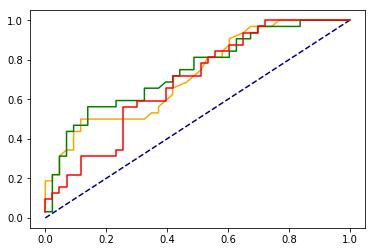

0.7205668604651162
0.7423691860465117
0.688953488372093


In [93]:
#Do a ROC curve for all 4 morphologies

features_all_train, features_all_test, y_train, y_test = train_test_split(features4, labels4, test_size=0.2, random_state=42)
model_bayes = GaussianNB()

y_score = model_bayes.fit(features_all_train[:,0].reshape(-1, 1), y_train).predict_proba(features_all_test[:,0].reshape(-1, 1))[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)

#Make an ROC curve
plt.plot(fpr, tpr, color='orange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

model_bayes2 = GaussianNB()
y_score2 = model_bayes2.fit(features_all_train[:,[0,3]], y_train).predict_proba(features_all_test[:,[0,3]])[:, 1]
fpr2, tpr2, _ = roc_curve(y_test, y_score2)
plt.plot(fpr2, tpr2, color='green')

model_bayes4 = GaussianNB()
y_score4 = model_bayes4.fit(features_all_train, y_train).predict_proba(features_all_test)[:, 1]
fpr4, tpr4, _ = roc_curve(y_test, y_score4)
plt.plot(fpr4, tpr4, color='red')
plt.show()

print(auc(fpr, tpr))
print(auc(fpr2, tpr2))

print(auc(fpr4, tpr4))


